# Classical Runge Kutta

Exam Question 5

Consider the initial value problems (1) and (2). In this problem you must describe the classical Runge-Kutta method for solution of thse problems, implement a solver, and test it for the test problems describes in problem 1.

In [237]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import time
import seaborn as sns
from typing import Tuple
import numpy as np
from scipy.sparse import diags

# Prey predator function valuation; if 4 parameters often called Lotka-Volterra
def PreyPredator(t:float, x:np.ndarray|list|Tuple[float, float], params:Tuple[float, float]=(1, 0.8)) -> np.ndarray:
    a, b = params
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return np.array([dx1, dx2])

# Jacobian of prey predator evaluated at x(t)
def PreyPredator_Jac(t:float, x:np.ndarray|list|Tuple[float, float], params:Tuple=(1, 0.8)) -> np.ndarray:
    x1, x2 = x
    a, b = params
    dx1x1 = a * (1 - x2) 
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)
    return np.array([[dx1x1, dx1x2], [dx2x1, dx2x2]])

# Prey predator function and jacobian
def PreyPredator_Fun_Jac(t:float, x:float|np.ndarray|list, params:Tuple[float, float]=(1, 0.8)) ->Tuple[np.ndarray, np.ndarray]:
    return PreyPredator(t, x, params), PreyPredator_Jac(t, x, params)

# Van Der Pol Oscillator function
def VanDerPol(t:float, x:np.ndarray|list|Tuple[float, float], params:Tuple[float]=(10)) -> np.ndarray:
    mu = params
    x1_ = x[1]
    x2_ = mu*(1-x[0]**2)*x[1]-x[0]
    return np.array([x1_,x2_])

def VanDerPol_Jac(t:float, x:np.ndarray|list|Tuple[float, float], params:Tuple[float]=(10)) -> np.ndarray:
    mu = params
    x1, x2 = x
    return np.array([[0, 1],[-2 * mu * x1 * x2 - 1, mu * (1 - x1**2)]])

def VanDerPol_Fun_Jac(t:float, x:np.ndarray|list|Tuple[float, float], params:Tuple[float]=(10)) -> Tuple[np.ndarray, np.ndarray]:
    return VanDerPol(t,x,params), VanDerPol_Jac(t,x,params)

### CSTR CHEMICAL REACTOR

# constants
deltaHr = -560               # kJ/mol
rho = 1.0                    # kg/L
cp = 4.186                   # kJ/(kg*K)
Ea_over_R = 8500             # K
k0 = np.exp(24.6)            # L/(mol*s)
V = 0.105                    # L (from Wahlgreen 2020)
F = 0.1                      # L/s  (assumed constant flowrate, realistic)

# initialisations
C0 = np.array([3.4, 3.7, 200])          # Initial condition
Cin = C0 + np.array([0.03, -0.04, -10])     # Assume inlet concentration = initial for now

CSTR3_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin)
CSTR3_param_type = Tuple[float, float, float, float, float, float, float, np.ndarray]

def CSTR3(t:float, C_states:np.ndarray|list|Tuple[float, float, float]=C0, params:CSTR3_param_type=CSTR3_PARAMS) -> np.ndarray:
    deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin = params

    # robustness
    T = max(C_states[2], 1e-3)  # prevent underflow
    T = max(T, 1e-3)            # add temperature lower bound to avoid 0 division error

    # State variables
    CA, CB, T = C_states

    # Arrhenius law
    k = k0 * np.exp(-Ea_over_R/T)

    # Reaction model
    r = k * CA * CB
    beta = -deltaHr / (rho * cp)
    v = np.array([-1, -2, beta])  # stoichiometric vector

    # Reaction term
    R = v * r

    # CSTR dynamics
    dCdt = (Cin - C_states) * F / V + R

    return np.array(dCdt)


def CSTR3_Jac(t: float, C_states: np.ndarray|list=C0, params:CSTR3_param_type=CSTR3_PARAMS) -> np.ndarray:
    deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin = params

    # State variables
    CA, CB, T = C_states

    # Safety check (avoid division by zero or overflow)
    if T < 1e-5:
        raise ValueError("Temperature too low — possible singularity in Jacobian.")

    # Arrhenius law
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    beta = -deltaHr / (rho * cp)

    # Derivatives
    dk_dT = (Ea_over_R / T**2) * k
    dr_dCA = k * CB
    dr_dCB = k * CA
    #dr_dT  = -Ea_over_R / T**2 * r  # product rule: d(k CA CB)/dT
    dr_dT = dk_dT * CA * CB

    # Partial derivatives of R = v * r
    v = np.array([-1, -2, beta])

    # Construct Jacobian
    J = np.empty((3, 3))

    # d(CA)/dt
    J[0, 0] = -F/V + v[0] * dr_dCA
    J[0, 1] =        v[0] * dr_dCB
    J[0, 2] =        v[0] * dr_dT

    # d(CB)/dt
    J[1, 0] =        v[1] * dr_dCA
    J[1, 1] = -F/V + v[1] * dr_dCB
    J[1, 2] =        v[1] * dr_dT

    # d(T)/dt
    J[2, 0] =        v[2] * dr_dCA
    J[2, 1] =        v[2] * dr_dCB
    J[2, 2] = -F/V + v[2] * dr_dT

    return J


def CSTR3_Fun_Jac(t:float, C_states:np.ndarray|list|Tuple[float, float, float]=C0, params:CSTR3_param_type=CSTR3_PARAMS) -> Tuple[np.ndarray, np.ndarray]:
    return CSTR3(t, C_states, params), CSTR3_Jac(t, C_states, params)



# constants; same as CSTR3 plus... [Wahlgreen et al. (2020)]
CA_in = 1.6/2                # mol/L
CB_in = 2.4/2                # mol/L

# initial conditions
T0 = 273.15                 # initial reactor temperature
Tin = 273.15                # inlet feed temperature

CSTR1_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin)
CSTR1_param_type = Tuple[float, float, float, float, float, float, float, float, float, float, float]

def CSTR1(t:float, T_state:float, params:CSTR1_param_type=CSTR1_PARAMS) -> float:
    if type(T_state)==list: 
        T_state = T_state[0]
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)

    CA = CA_in + 1/beta * (T0-T_state)
    CB = CB_in + 2/beta * (T0-T_state)

    k = k0 * np.exp(-Ea_over_R/T_state)
    r = k * CA * CB

    dTdt = (Tin - T_state) * F/V + beta * r

    return dTdt

def CSTR1_Jac(t:float, T_state:float, params:CSTR1_param_type=CSTR1_PARAMS) -> np.ndarray:
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)

    CA = CA_in + (1/beta)*(T0 - T_state)
    CB = CB_in + (2/beta)*(T0 - T_state)

    k = k0 * np.exp(-Ea_over_R / T_state)
    r = k * CA * CB    

    # Derivatives
    dk_dT = (Ea_over_R / T_state**2) * k
    dCA_dT = -1/beta
    dCB_dT = -2/beta

    # Full derivative using product rule
    dr_dT = dk_dT * CA * CB + k * dCA_dT * CB + k * CA * dCB_dT

    # return Jacobian, bc 1D simply derivative
    return np.array([-F/V + beta * dr_dT])

def CSTR1_Fun_Jac(t:float, T_state:float, params:CSTR1_param_type=CSTR1_PARAMS) -> Tuple[float, np.ndarray]:
    return CSTR1(t, T_state, params), CSTR1_Jac(t, T_state, params)



def PFR_3state(t, C, Cin, p):
    # Storing inlet concentration/temperature
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    A = 0.1
    vol= F/A

    # Hardcoding variables
    k0 = np.exp(24.6) 
    DA = 0.1
    DB = 0.1
    DT = 0.1

    # Extracting initial values
    CA = C[0:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]
                 
    Ea_over_R = 8500             
    
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    
    # Convection at finite volume interfaces
    NconvA = np.zeros(n+1)
    NconvA[0] = vol * CAin
    NconvA[1:n+1] = vol * CA[0:n]
    
    NconvB = np.zeros(n+1)
    NconvB[0] = vol * CBin
    NconvB[1:n+1] = vol * CB[0:n]

    NconvT = np.zeros(n+1)
    NconvT[0] = vol * Tin
    NconvT[1:n+1] = vol * T[0:n]
    
    # Diffusion at finite volume interfaces
    JA = np.zeros(n+1) # no diffusion at inlet or outlet
    JA[1:n] = (-DA/dz) * (CA[1:n] - CA[0:n-1])

    JB = np.zeros(n+1)
    JB[1:n] = (-DB/dz) * (CB[1:n] - CB[0:n-1])

    JT = np.zeros(n+1)
    JT[1:n] = (-DT/dz) * (T[1:n] - T[0:n-1])
    
    # Flux = convection + diffusion
    NA = NconvA + JA
    NB = NconvB + JB
    NT = NconvT + JT
    
    # Reaction and production rates in finite volumes
    r = k * CA * CB
    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r
    
    # Differential Equations (mass balances at finite volumes)
    CAdot = (NA[1:n+1] - NA[0:n])/(-dz) + RA
    CBdot = (NB[1:n+1] - NB[0:n])/(-dz) + RB
    Tdot = (NT[1:n+1] - NT[0:n])/(-dz) + RT
    
    return np.vstack([CAdot, CBdot, Tdot]).flatten()


def PFR_3state_Jac(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    
    k0 = np.exp(24.6)
    DA = 0.1
    DB = 0.1
    DT = 0.1
    
    deltaHr = -560
    rho = 1.0
    cp = 4.186
    Ea_over_R = 8500
    beta = -deltaHr / (rho * cp)

    CA = np.maximum(C[0:n],0.0)
    CB = np.maximum(C[n:2*n],0.0)
    T = C[2*n:3*n]
    
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    
    J = np.zeros((3*n, 3*n))
    
    for i in range(n):
        # Index ranges
        iA = i
        iB = n + i
        iT = 2*n + i

        # Reaction derivatives
        dkdT = k[i] * (Ea_over_R / (T[i]**2))
        drdCA = k[i] * CB[i]
        drdCB = k[i] * CA[i]
        drdT  = dkdT * CA[i] * CB[i]

        # Reaction terms (RA, RB, RT)
        dRA_dCA = -drdCA
        dRA_dCB = -drdCB
        dRA_dT  = -drdT

        dRB_dCA = -2*drdCA
        dRB_dCB = -2*drdCB
        dRB_dT  = -2*drdT

        dRT_dCA = beta * drdCA
        dRT_dCB = beta * drdCB
        dRT_dT  = beta * drdT

        # Convection and diffusion terms (finite volume discretization)
        for species, D, idx in zip([CA, CB, T], [DA, DB, DT], [iA, iB, iT]):
            if i > 0:
                J[idx, idx - 1] += D / dz**2
                J[idx, idx]     -= D / dz**2
            if i < n-1:
                J[idx, idx]     -= D / dz**2
                J[idx, idx + 1] += D / dz**2

        # Reaction contributions
        J[iA, iA] += dRA_dCA
        J[iA, iB] += dRA_dCB
        J[iA, iT] += dRA_dT

        J[iB, iA] += dRB_dCA
        J[iB, iB] += dRB_dCB
        J[iB, iT] += dRB_dT

        J[iT, iA] += dRT_dCA
        J[iT, iB] += dRT_dCB
        J[iT, iT] += dRT_dT

    return J 

def PFR_1state(t, T, Tin, p):
    CA_in, CB_in, T_in = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    deltaHr = -560               
    rho = 1.0                   
    cp = 4.186  
    beta = -deltaHr / (rho * cp)   

    CA = CA_in + 1/beta * (T_in-T)
    CB = CB_in + 2/beta * (T_in-T)
    DT=0.1

    k0 = np.exp(24.6)
    Ea_over_R = 8500             
    
    k = k0 * np.exp(-Ea_over_R / T)


    r= k * CA * CB
    RT = v * r

    F = 50
    A = 0.1
    vol= F/A
    
    # Initialize flux
    NT = np.zeros(n + 1)

    # Flux boundaries (1/2 indexing):
    NconvT = np.zeros(n+1)
    NconvT[0] = vol * T_in
    NconvT[1:n+1] = vol * T[0:n]

    JT = np.zeros(n+1)
    JT[1:n] = (-DT/dz) * (T[1:n] - T[0:n-1])
    
    # Flux = convection + diffusion
    NT = NconvT + JT
    
    # Compute dT/dt
    Tdot = (NT[1:n+1] - NT[0:n])/(-dz) + RT
    return Tdot

def PFR1_Jac(t, T, u, p):
    Nz = p["Nz"]
    dz = p["dz"]
    v = p["v"]
    DT = p["DT"]

    main_diag = np.full(Nz, v / dz + 2 * DT / dz**2)
    upper_diag = np.full(Nz - 1, -DT / dz**2)
    lower_diag = np.full(Nz - 1, -DT / dz**2 - v / dz)

    J = diags([main_diag, upper_diag, lower_diag], [0, 1, -1], format='csr')
    return J


## Runge Kutta fixed step size

In [238]:
def RungeKuttaFixedStep(fun, t0, x0, h, N, A, b, c, *args):
    x0 = np.array(x0)
    s = len(b) 
    d = len(x0)

    Tout = np.zeros(N + 1)
    Xout = np.zeros((N + 1, d))

    t = t0
    x = x0.copy()

    Tout[0] = t
    Xout[0] = x

    for n in range(N):
        T = np.zeros(s)
        X = np.zeros((d, s))
        F = np.zeros((d, s))

        # Stage 1
        T[0] = t
        X[:, 0] = x
        F[:, 0] = np.asarray(fun(T[0], X[:, 0], *args))

        # Stage 2 to s
        for i in range(1, s):
            T[i] = t + h * c[i]
            X[:, i] = x + h * F[:, :i] @ A[:i, i]
            F[:, i] = np.asarray(fun(T[i], X[:, i], *args))

        # Next step
        t = t + h
        x = x + h * F @ b
        
        Tout[n + 1] = t
        Xout[n + 1] = x

    return Tout, Xout




## Testing fixed step size
### Prey predator

In [239]:
# Butcher tableau for classic RK4
A = np.array([
    [0,   0,   0, 0],
    [0.5, 0,   0, 0],
    [0,   0.5, 0, 0],
    [0,   0,   1, 0]
])
b = np.array([1/6, 1/3, 1/3, 1/6])
c = np.array([0, 0.5, 0.5, 1.0])

# Initial conditions and settings
t0 = 0
t_span=np.array([0,20])
h = 0.1
N = 250


x0_pp = [3.0, 2.0]

# Run the solver
Tout, Xout = RungeKuttaFixedStep(PreyPredator, t0, x0_pp, h, N, A, b, c)



### Van der pol

In [240]:
# Initial conditions and settings

mu = 10
x0 = np.array([2.0, 0.0])
t_span = (0, 20)
t0 = t_span[0]
TN = t_span[1]
h=0.1
N = 100

# Run the solver
Tout, Xout = RungeKuttaFixedStep(VanDerPol, t0, x0, h, N, A, b, c, mu)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_14724\2652365652.py:37: RuntimeWarning: overflow encountered in scalar multiply
  x2_ = mu*(1-x[0]**2)*x[1]-x[0]
C:\Users\Bruger\AppData\Local\Temp\ipykernel_14724\3770525820.py:28: RuntimeWarning: invalid value encountered in matmul
  X[:, i] = x + h * F[:, :i] @ A[:i, i]


## CSTR

In [241]:
# Initial conditions and settings
# Run the solver
Tout, Xout = RungeKuttaFixedStep(CSTR3, t0, C0, h, N, A, b, c)


In [242]:

# Set initial and inlet conditions
T0 = np.array([273.15])       # initial reactor temperature
Tin = np.array([273.15])     # inlet feed temperature

t_span = (0, 20)
t0 = t_span[0]
TN = t_span[1]
h=0.1
N = 50

# Run the solver
Tout, Xout = RungeKuttaFixedStep(CSTR1, t0, T0, h, N, A, b, c)


## PFR

#

In [243]:
# Discretization parameters
Nz = 50
L = 10

# reaction velocity
deltaHr = -560               
rho = 1.0                   
cp = 4.186  
beta = -deltaHr / (rho * cp)   
v = np.array([-1, -2, beta])
F = 50

# Derived Parameters
deltaz = L / Nz

# Pack parameters into a dictionary
p = {
    'Nz': Nz,
    'dz': deltaz,
    'v': v,
    'F': F
}
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

Cin = np.array([1.6/2, 2.4/2,600]) # Assume inlet concentration = initial for now

# Initial conditions and settings
t0 = 0
h = 0.0001
N = 200

# Run the solver
Tout, Xout = RungeKuttaFixedStep(PFR_3state, t0, C0, h, N, A, b, c, Cin, p)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_14724\2652365652.py:221: RuntimeWarning: overflow encountered in multiply
  r = k * CA * CB
C:\Users\Bruger\AppData\Local\Temp\ipykernel_14724\2652365652.py:252: RuntimeWarning: overflow encountered in multiply
  r = k * CA * CB
C:\Users\Bruger\AppData\Local\Temp\ipykernel_14724\3770525820.py:28: RuntimeWarning: invalid value encountered in matmul
  X[:, i] = x + h * F[:, :i] @ A[:i, i]


## Runge kutta adaptive step size

In [244]:
def ClassicalRungeKuttaStep(fun,t,x,f,h,*args):
    h2 = 0.5*h      # Half the step size
    alpha = h/6     # Weight for F1, F4
    beta = h/3      # Weight for F2, F3

    x = np.array(x, dtype=float)  # Ensure x is a NumPy array
    t = np.array(t, dtype=float)  # Ensure x is a NumPy array
    f = np.array(f, dtype=float)  # Ensure x is a NumPy array

    T1=t
    X1=x
    F1=f

    # Half a step
    T2 = t+h2
    X2 = x+h2*F1 
    F2 = np.array(fun(T2,X2,*args))
    
    T3=T2
    X3 = x+h*F2
    F3 = np.array(fun(T3, X3, *args))

    T4 = t+h
    X4 = x+h*F3
    F4 = np.array(fun(T4,X4,*args))

    t1 = T4
    x1 = x + alpha*(F1+F4)+beta*(F2+F3)  

    return t1, x1


def ClassicalRungeKuttaAdaptiveStep(fun,tspan,x0,h0,abstol,reltol,*args):
    # Error controller parameters
    epstol = 0.8  # Safety factor
    facmin = 0.1  # Maximum decrease factor
    facmax = 5.0  # Maximum increase factor

    # Integration interval
    t0, tf = tspan

    # Initial conditions
    t = t0
    h = h0
    x = np.array(x0, dtype=float)  # Ensure x is a NumPy array
    #print("first time iteration")
    # Counters
    nfun = 0
    naccept = 0
    nreject = 0
    
    # Output storage
    T = np.array([t])  # Ensure T is a 1D NumPy array
    X = np.array([x])  # Ensure X is a 2D NumPy array
    E = np.array(np.zeros(np.shape(x))) # Local error

    max_steps = 100000
    max_rejects = 1000 

    while t < tf and naccept < max_steps:

        if (t+h > tf):
            h = tf-t

        f = fun(t,x,*args)
        AcceptStep = False

        while not AcceptStep:
            t1,x1 = ClassicalRungeKuttaStep(fun,t,x,f,h,*args)

            hm = 0.5*h
            
            tm,xm = ClassicalRungeKuttaStep(fun,t,x,f,hm,*args)

            fm = fun(tm,xm,*args)
            
            t1hat,x1hat = ClassicalRungeKuttaStep(fun,tm,xm,fm,hm,*args)

            # Number of function calls
            nfun+=12            
            e = np.array(x1hat -x1)

            denom = np.maximum(abstol, np.abs(x1hat) * reltol)  # Fix element-wise max
            r = np.max(np.abs(e) / denom)  # Compute max ratio
        
            AcceptStep = (r <= epstol)

            if AcceptStep:

                
                t = t + h
                x = x1hat
                naccept+=1

                T = np.append(T, t)  # Append t to the 1D array
                X = np.vstack([X, x1hat.reshape(1, -1)])  # Ensure correct shape
                E = np.vstack([E, np.abs(e.reshape(1, -1))])

            else: 
                nreject+=1

                if nreject >= max_rejects:
                    print(f"Warning: step rejected too many times at t={t:.5f}. Aborting.")
                    return T, X, E, nfun, naccept, nreject
            
            h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h

    
    return T, X, E, nfun, naccept, nreject


## Testing adaptive step

Adaptive step performance
Number of function calls 3876
Number of accepted steps 197
Number of rejected steps 126
Runtime: 0.0818 seconds
Fixed step performance
Number of function calls 3876
Runtime: 0.1689 seconds
BDF  performance
Number of function calls 327
Number of jacobian calls 10
Runtime: 0.0303 seconds
RK45  performance
Number of function calls 206
Number of jacobian calls 0
Runtime: 0.0303 seconds


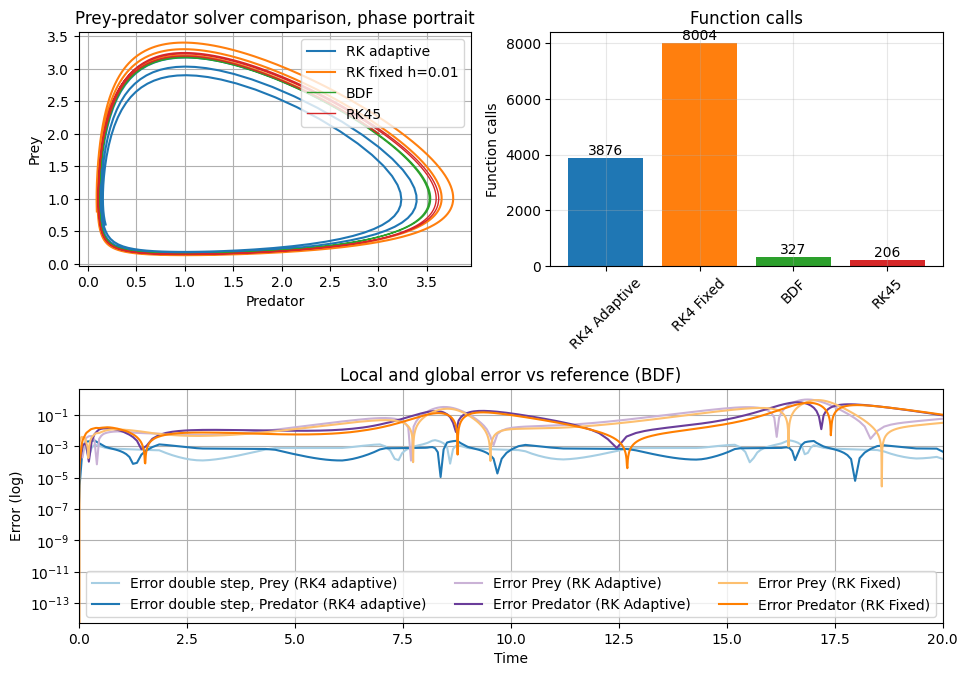

In [260]:
reltol=1e-3
abstol=1e-3
h0=1e-6
tspan = (0, 20)
x0=np.array([1.0,2.0])

# Run the solver
start_time = time.time()
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(PreyPredator,tspan,x0_pp,h0,abstol,reltol)
runtime_adaptive = time.time() - start_time

print("Adaptive step performance")
print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
print(f"Runtime: {runtime_adaptive:.4f} seconds")

# Run the fixed 
h=0.01
N=np.ceil(tspan[1]/h).astype(int)
start_time = time.time()
Toutfixed, Xoutfixed = RungeKuttaFixedStep(PreyPredator, t0, x0_pp, h, N, A, b, c)
runtime_fixed = time.time() - start_time
nfun_fixed = len(Toutfixed) * len(b)  

print("Fixed step performance")
print("Number of function calls", nfun)
print(f"Runtime: {runtime_fixed:.4f} seconds")

# Benchmarking 
t_eval = np.linspace(t_span[0], t_span[1], 1000)

start_time = time.time()
sol_ode15s = solve_ivp(PreyPredator, t_span, x0_pp, t_eval=t_eval, method='BDF',jac = PreyPredator_Jac)
runtime_bdf = time.time() - start_time
print("BDF  performance")
print("Number of function calls", sol_ode15s.nfev)
print("Number of jacobian calls", sol_ode15s.njev)
print(f"Runtime: {runtime_bdf:.4f} seconds")
start_time = time.time()
sol_ode45 = solve_ivp(PreyPredator, t_span, x0_pp, t_eval=t_eval, method='RK45')
runtime_rk45 = time.time() - start_time
print("RK45  performance")
print("Number of function calls", sol_ode45.nfev)
print("Number of jacobian calls", sol_ode45.njev)
print(f"Runtime: {runtime_bdf:.4f} seconds")
# Global error
# Adaptive
prey_interp = interp1d(sol_ode15s.t, sol_ode15s.y[0], kind='cubic')
pred_interp = interp1d(sol_ode15s.t, sol_ode15s.y[1], kind='cubic')
global_err_prey = np.abs(Xout[:, 0] - prey_interp(Tout))
global_err_pred = np.abs(Xout[:, 1] - pred_interp(Tout))
# Fixed
prey_interp_fixed = interp1d(sol_ode15s.t, sol_ode15s.y[0], kind='cubic',bounds_error=False, fill_value='extrapolate')
pred_interp_fixed = interp1d(sol_ode15s.t, sol_ode15s.y[1], kind='cubic',bounds_error=False, fill_value='extrapolate')
global_err_fixed_prey = np.abs(Xoutfixed[:, 0] - prey_interp_fixed(Toutfixed))
global_err_fixed_pred = np.abs(Xoutfixed[:, 1] - pred_interp_fixed(Toutfixed))

nfun_bdf = sol_ode15s.nfev
nfun_rk45 = sol_ode45.nfev


fig = plt.figure(figsize=(10, 10))

# Create subplots using subplot2grid for better control
ax1 = plt.subplot2grid((3, 2), (0, 0))  # Top left
ax2 = plt.subplot2grid((3, 2), (0, 1))  # Top right
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)  # Middle row, spanning both columns

# 1. Prey-Predator Phase Portrait (top left)
ax1.plot(Xout[:, 0], Xout[:, 1], label='RK adaptive', lw=1.5)
ax1.plot(Xoutfixed[:, 0], Xoutfixed[:, 1], label=f'RK fixed h={h}', lw=1.5)
ax1.plot(sol_ode15s.y[0], sol_ode15s.y[1], label='BDF', lw=1)
ax1.plot(sol_ode45.y[0], sol_ode45.y[1], label='RK45', lw=1)
ax1.set_ylabel("Prey")
ax1.set_xlabel("Predator")
ax1.set_title("Prey-predator solver comparison, phase portrait")
ax1.legend(loc='upper right')
ax1.grid(True)

# 2. function calls
methods = ['RK4 Adaptive', 'RK4 Fixed', 'BDF', 'RK45']
runtimes = [nfun, nfun_fixed, sol_ode15s.nfev, sol_ode45.nfev]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
bars = ax2.bar(methods, runtimes, color=colors)
ax2.set_ylabel("Function calls")
ax2.set_title("Function calls")
ax2.grid(True, alpha=0.3)
# Add value labels on bars
for bar, runtime in zip(bars, runtimes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{runtime}', ha='center', va='bottom')
# Rotate x-axis labels for better readability
ax2.tick_params(axis='x', rotation=45)


colors = sns.color_palette("Paired")

# 4. Global Error vs BDF (bottom row, spanning both columns)
ax3.plot(Tout, E[:, 0], label='Error double step, Prey (RK4 adaptive)', color=colors[0])
ax3.plot(Tout, E[:, 1], label='Error double step, Predator (RK4 adaptive)', color=colors[1])
ax3.plot(Tout, global_err_prey, label='Error Prey (RK Adaptive)', color=colors[8])
ax3.plot(Tout, global_err_pred, label='Error Predator (RK Adaptive)', color=colors[9])
ax3.plot(Toutfixed, global_err_fixed_prey, label='Error Prey (RK Fixed)', color=colors[6])
ax3.plot(Toutfixed, global_err_fixed_pred, label='Error Predator (RK Fixed)', color=colors[7])
ax3.set_yscale("log")
ax3.set_ylabel("Error (log)")
ax3.set_xlabel("Time")
ax3.set_title("Local and global error vs reference (BDF)")
ax3.legend(bbox_to_anchor=(0.5, 0.25), loc='upper center', ncol=3)
ax3.set_xlim([t_span[0], t_span[1]])
ax3.grid(True)

plt.tight_layout()
plt.show()

Adaptive step performance
Number of function calls 7296
Number of accepted steps 309
Number of rejected steps 299
Runtime: 0.1213 seconds
Fixed step performance
Number of function calls 2004
Runtime: 0.0486 seconds
BDF performance
Number of function calls 644
Number of jacobian calls 26
Runtime: 0.0963 seconds
RK45 performance
Number of function calls 956
Number of jacobian calls 0
Runtime: 0.0263 seconds


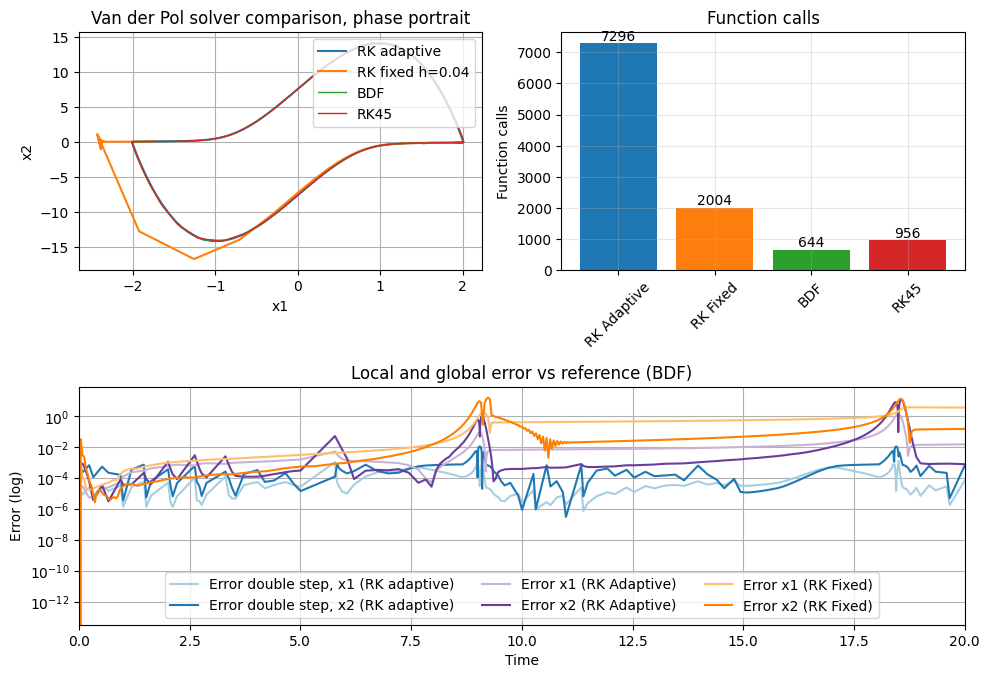

In [265]:
# Define t_span and parameters
t_span = (0, 20)
t0 = t_span[0]
h = 0.04
reltol = 1e-3
abstol = 1e-3
h0 = 1e-6
mu = 10
x0_vdp = np.array([2.0, 0.0])

# Adaptive RK4 Solver
start_time = time.time()
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(VanDerPol, t_span, x0_vdp, h0, abstol, reltol, mu)
runtime_adaptive = time.time() - start_time

print("Adaptive step performance")
print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
print(f"Runtime: {runtime_adaptive:.4f} seconds")

# Fixed-step RK4 Solver
N = np.ceil(t_span[1] / h).astype(int)
start_time = time.time()
Toutfixed, Xoutfixed = RungeKuttaFixedStep(VanDerPol, t0, x0_vdp, h, N, A, b, c, mu)
runtime_fixed = time.time() - start_time
nfun_fixed = len(Toutfixed) * len(b)

print("Fixed step performance")
print("Number of function calls", nfun_fixed)
print(f"Runtime: {runtime_fixed:.4f} seconds")

# Benchmarking with solve_ivp
t_eval = np.linspace(t_span[0], t_span[1], 1000)

start_time = time.time()
sol_ode15s = solve_ivp(VanDerPol, t_span, x0_vdp, args=(mu,), t_eval=t_eval, method='BDF', jac=VanDerPol_Jac)
runtime_bdf = time.time() - start_time
print("BDF performance")
print("Number of function calls", sol_ode15s.nfev)
print("Number of jacobian calls", sol_ode15s.njev)
print(f"Runtime: {runtime_bdf:.4f} seconds")

start_time = time.time()
sol_ode45 = solve_ivp(VanDerPol, t_span, x0_vdp, args=(mu,), t_eval=t_eval, method='RK45')
runtime_rk45 = time.time() - start_time
print("RK45 performance")
print("Number of function calls", sol_ode45.nfev)
print("Number of jacobian calls", sol_ode45.njev)
print(f"Runtime: {runtime_rk45:.4f} seconds")

# Global error vs BDF
x1_interp = interp1d(sol_ode15s.t, sol_ode15s.y[0], kind='cubic')
x2_interp = interp1d(sol_ode15s.t, sol_ode15s.y[1], kind='cubic')
global_err_x1 = np.abs(Xout[:, 0] - x1_interp(Tout))
global_err_x2 = np.abs(Xout[:, 1] - x2_interp(Tout))

x1_interp_fixed = interp1d(sol_ode15s.t, sol_ode15s.y[0], kind='cubic', bounds_error=False, fill_value='extrapolate')
x2_interp_fixed = interp1d(sol_ode15s.t, sol_ode15s.y[1], kind='cubic', bounds_error=False, fill_value='extrapolate')
global_err_fixed_x1 = np.abs(Xoutfixed[:, 0] - x1_interp_fixed(Toutfixed))
global_err_fixed_x2 = np.abs(Xoutfixed[:, 1] - x2_interp_fixed(Toutfixed))

# Plotting
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)

# Phase portrait
ax1.plot(Xout[:, 0], Xout[:, 1], label='RK adaptive', lw=1.5)
ax1.plot(Xoutfixed[:, 0], Xoutfixed[:, 1], label=f'RK fixed h={h}', lw=1.5)
ax1.plot(sol_ode15s.y[0], sol_ode15s.y[1], label='BDF', lw=1)
ax1.plot(sol_ode45.y[0], sol_ode45.y[1], label='RK45', lw=1)
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_title("Van der Pol solver comparison, phase portrait")
ax1.legend(loc='upper right')
ax1.grid(True)

# Runtime comparison
methods = ['RK Adaptive', 'RK Fixed', 'BDF', 'RK45']
funevals = [nfun, nfun_fixed, sol_ode15s.nfev, sol_ode45.nfev]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
bars = ax2.bar(methods, funevals, color=colors)
ax2.set_ylabel("Function calls")
ax2.set_title("Function calls")
ax2.grid(True, alpha=0.3)
for bar, funeval in zip(bars, funevals):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{funeval}', ha='center', va='bottom')
ax2.tick_params(axis='x', rotation=45)

# Global error plot
colors = sns.color_palette("Paired")
ax3.plot(Tout, E[:, 0], label='Error double step, x1 (RK adaptive)', color=colors[0])
ax3.plot(Tout, E[:, 1], label='Error double step, x2 (RK adaptive)', color=colors[1])
ax3.plot(Tout, global_err_x1, label='Error x1 (RK Adaptive)', color=colors[8])
ax3.plot(Tout, global_err_x2, label='Error x2 (RK Adaptive)', color=colors[9])
ax3.plot(Toutfixed, global_err_fixed_x1, label='Error x1 (RK Fixed)', color=colors[6])
ax3.plot(Toutfixed, global_err_fixed_x2, label='Error x2 (RK Fixed)', color=colors[7])
ax3.set_yscale("log")
ax3.set_ylabel("Error (log)")
ax3.set_xlabel("Time")
ax3.set_title("Local and global error vs reference (BDF)")
ax3.legend(bbox_to_anchor=(0.5, 0.25), loc='upper center', ncol=3)
ax3.set_xlim([t_span[0], t_span[1]])
ax3.grid(True)

plt.tight_layout()
plt.show()

Adaptive step performance
Number of function calls 60
Number of accepted steps 5
Number of rejected steps 0
Runtime: 0.0024 seconds
Fixed step performance
Number of function calls 204
Runtime: 0.0123 seconds
BDF performance
Number of function calls 25
Number of jacobian calls 1
Runtime: 0.0060 seconds
RK45 performance
Number of function calls 26
Number of jacobian calls 0
Runtime: 0.0014 seconds


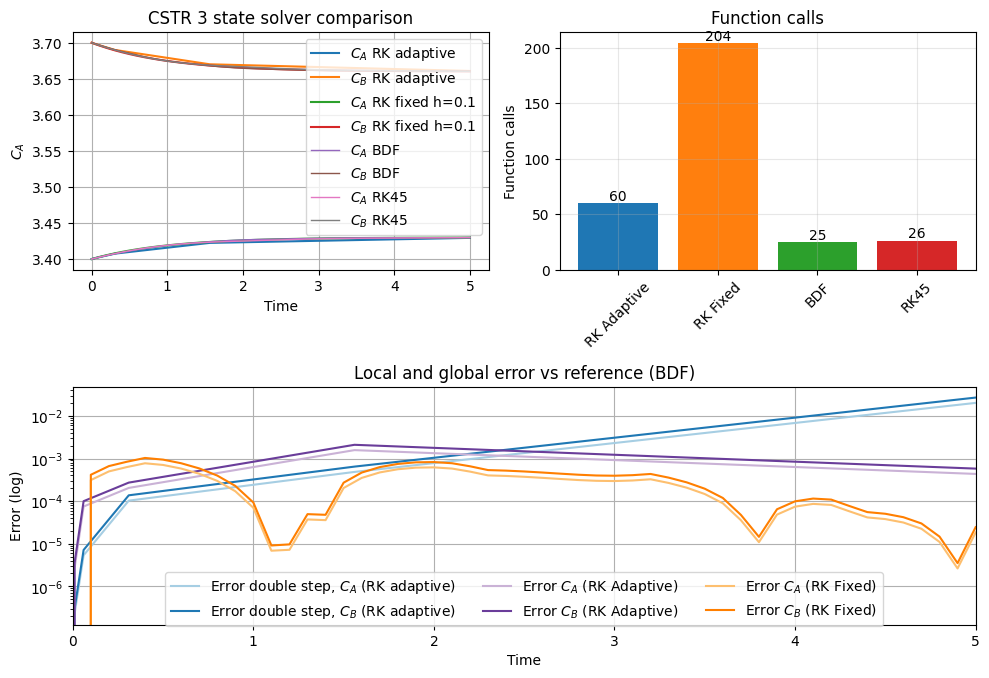

In [313]:
# Settings
h = 0.1
reltol = 1e-1
abstol = 1e-1
h0 = 1e-2
t_span = (0, 5)
t0 = t_span[0]

# Initial condition
C0 = np.array([3.4, 3.7, 200])


# Adaptive RK4 Solver
start_time = time.time()
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(CSTR3, t_span, C0, h0, abstol, reltol)
runtime_adaptive = time.time() - start_time

print("Adaptive step performance")
print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
print(f"Runtime: {runtime_adaptive:.4f} seconds")

# Fixed-step RK4 Solver
N = np.ceil(t_span[1] / h).astype(int)
start_time = time.time()
Toutfixed, Xoutfixed = RungeKuttaFixedStep(CSTR3, t0, C0, h, N, A, b, c)
runtime_fixed = time.time() - start_time
nfun_fixed = len(Toutfixed) * len(b)

print("Fixed step performance")
print("Number of function calls", nfun_fixed)
print(f"Runtime: {runtime_fixed:.4f} seconds")

# Benchmarking with solve_ivp
t_eval = np.linspace(t_span[0], t_span[1], 1000)

start_time = time.time()
sol_ode15s = solve_ivp(CSTR3, t_span, C0, t_eval=t_eval, method='BDF', jac=CSTR3_Jac)
runtime_bdf = time.time() - start_time
nfun_bdf = sol_ode15s.nfev

start_time = time.time()
sol_ode45 = solve_ivp(CSTR3, t_span, C0, t_eval=t_eval, method='RK45')
runtime_rk45 = time.time() - start_time
nfun_rk45 = sol_ode45.nfev

print("BDF performance")
print("Number of function calls", nfun_bdf)
print("Number of jacobian calls", sol_ode15s.njev)
print(f"Runtime: {runtime_bdf:.4f} seconds")

print("RK45 performance")
print("Number of function calls", nfun_rk45)
print("Number of jacobian calls", sol_ode45.njev)
print(f"Runtime: {runtime_rk45:.4f} seconds")

# Global error vs BDF
interp_funcs = [interp1d(sol_ode15s.t, sol_ode15s.y[i], kind='cubic', bounds_error=False, fill_value='extrapolate') for i in range(2)]
global_err_adaptive = [np.abs(Xout[:, i] - interp_funcs[i](Tout)) for i in range(2)]
global_err_fixed = [np.abs(Xoutfixed[:, i] - interp_funcs[i](Toutfixed)) for i in range(2)]

# Plotting
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)

# State trajectories
ax1.plot(Tout, Xout[:, 0], label='$C_A$ RK adaptive', lw=1.5)
ax1.plot(Tout, Xout[:, 1], label='$C_B$ RK adaptive', lw=1.5)
ax1.plot(Toutfixed, Xoutfixed[:, 0], label=f'$C_A$ RK fixed h={h}', lw=1.5)
ax1.plot(Toutfixed, Xoutfixed[:, 1], label=f'$C_B$ RK fixed h={h}', lw=1.5)
ax1.plot(sol_ode15s.t, sol_ode15s.y[0], label='$C_A$ BDF', lw=1)
ax1.plot(sol_ode15s.t, sol_ode15s.y[1], label='$C_B$ BDF', lw=1)
ax1.plot(sol_ode45.t, sol_ode45.y[0], label='$C_A$ RK45', lw=1)
ax1.plot(sol_ode45.t, sol_ode45.y[1], label='$C_B$ RK45', lw=1)
ax1.set_ylabel("$C_A$")
ax1.set_xlabel("Time")
ax1.set_title("CSTR 3 state solver comparison")
ax1.legend(loc='upper right')
ax1.grid(True)

# Runtime comparison
methods = ['RK Adaptive', 'RK Fixed', 'BDF', 'RK45']
funevals = [nfun, nfun_fixed, nfun_bdf, nfun_rk45]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
bars = ax2.bar(methods, funevals, color=colors)
ax2.set_ylabel("Function calls")
ax2.set_title("Function calls")
ax2.grid(True, alpha=0.3)
for bar, funeval in zip(bars, funevals):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{funeval}', ha='center', va='bottom')
ax2.tick_params(axis='x', rotation=45)

# Global error plot
colors = sns.color_palette("Paired")
ax3.plot(Tout, E[:, 0], label='Error double step, $C_A$ (RK adaptive)', color=colors[0])
ax3.plot(Tout, E[:, 1], label='Error double step, $C_B$ (RK adaptive)', color=colors[1])
ax3.plot(Tout, global_err_adaptive[0], label='Error $C_A$ (RK Adaptive)', color=colors[8])
ax3.plot(Tout, global_err_adaptive[1], label='Error $C_B$ (RK Adaptive)', color=colors[9])
ax3.plot(Toutfixed, global_err_fixed[0], label='Error $C_A$ (RK Fixed)', color=colors[6])
ax3.plot(Toutfixed, global_err_fixed[1], label='Error $C_B$ (RK Fixed)', color=colors[7])
ax3.set_yscale("log")
ax3.set_ylabel("Error (log)")
ax3.set_xlabel("Time")
ax3.set_title("Local and global error vs reference (BDF)")
ax3.legend(bbox_to_anchor=(0.5, 0.25), loc='upper center', ncol=3)
ax3.set_xlim([t_span[0], t_span[1]])
ax3.grid(True)

plt.tight_layout()
plt.show()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_14724\709854683.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h


Adaptive step performance
Number of function calls 216
Number of accepted steps 16
Number of rejected steps 2
Runtime: 0.0157 seconds
Fixed step performance
Number of function calls 216
Runtime: 1.6408 seconds

Function evaluations comparison:
RK Adaptive: 216 function calls
RK Fixed: 40004 function calls
BDF: 16 function calls
RK45: 32 function calls


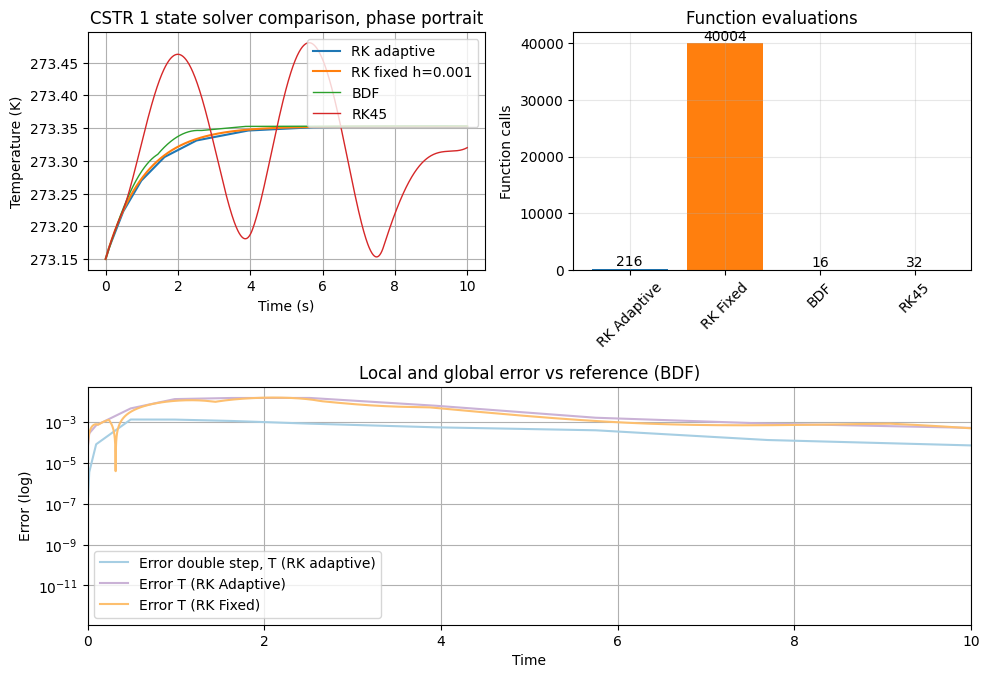

In [318]:
h=0.001
T0 = [273.15]     
reltol=1e-5
abstol=1e-5
h0=1e-6
tspan = (0, 10)

# Run the solver
start_time = time.time()
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(CSTR1,tspan,T0,h0,abstol,reltol)
runtime_adaptive = time.time() - start_time

print("Adaptive step performance")
print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
print(f"Runtime: {runtime_adaptive:.4f} seconds")

# Run the fixed 
N=np.ceil(tspan[1]/h).astype(int) 
start_time = time.time()
Toutfixed, Xoutfixed = RungeKuttaFixedStep(CSTR1, t0, T0, h, N, A, b, c)
runtime_fixed = time.time() - start_time
nfun_fixed = len(Toutfixed) * len(b)  

print("Fixed step performance")
print("Number of function calls", nfun)
print(f"Runtime: {runtime_fixed:.4f} seconds")

# Benchmarking 
t_eval = np.linspace(tspan[0], tspan[1], 1000)

start_time = time.time()
sol_ode15s = solve_ivp(CSTR1, tspan, T0, t_eval=t_eval, method='BDF',jac = CSTR1_Jac)
runtime_bdf = time.time() - start_time
start_time = time.time()
sol_ode45 = solve_ivp(CSTR1, tspan, T0, t_eval=t_eval, method='RK45')
runtime_rk45 = time.time() - start_time

# Global error
# Adaptive
prey_interp = interp1d(sol_ode15s.t, sol_ode15s.y[0], kind='cubic')
#pred_interp = interp1d(sol_ode15s.t, sol_ode15s.y[1], kind='cubic')
global_err_prey = np.abs(Xout[:, 0] - prey_interp(Tout))
#global_err_pred = np.abs(Xout[:, 1] - pred_interp(Tout))
# Fixed
prey_interp_fixed = interp1d(sol_ode15s.t, sol_ode15s.y[0], kind='cubic',bounds_error=False, fill_value='extrapolate')
#pred_interp_fixed = interp1d(sol_ode15s.t, sol_ode15s.y[1], kind='cubic',bounds_error=False, fill_value='extrapolate')
global_err_fixed_prey = np.abs(Xoutfixed[:, 0] - prey_interp_fixed(Toutfixed))
#global_err_fixed_pred = np.abs(Xoutfixed[:, 1] - pred_interp_fixed(Toutfixed))

nfun_bdf = sol_ode15s.nfev
nfun_rk45 = sol_ode45.nfev

# Print summary
print("\nFunction evaluations comparison:")
print(f"RK Adaptive: {nfun} function calls")
print(f"RK Fixed: {nfun_fixed} function calls")
print(f"BDF: {nfun_bdf} function calls")
print(f"RK45: {nfun_rk45} function calls")

# Create figure and subplots
fig = plt.figure(figsize=(10, 10))

# Subplot layout
ax1 = plt.subplot2grid((3, 2), (0, 0))  # Phase portrait
ax2 = plt.subplot2grid((3, 2), (0, 1))  # Function calls bar chart
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)  # Error plot

# Phase portrait
ax1.plot(Tout, Xout[:, 0], label='RK adaptive', lw=1.5)
ax1.plot(Toutfixed, Xoutfixed[:, 0], label=f'RK fixed h={h}', lw=1.5)
ax1.plot(sol_ode15s.t, sol_ode15s.y[0], label='BDF', lw=1)
ax1.plot(sol_ode45.t, sol_ode45.y[0], label='RK45', lw=1)
ax1.set_ylabel("Temperature (K)")
ax1.set_xlabel("Time (s)")
ax1.set_title("CSTR 1 state solver comparison, phase portrait")
ax1.legend(loc='upper right')
ax1.grid(True)

# Function call bar chart
methods = ['RK Adaptive', 'RK Fixed', 'BDF', 'RK45']
function_calls = [nfun, nfun_fixed, nfun_bdf, nfun_rk45]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
bars = ax2.bar(methods, function_calls, color=colors)
ax2.set_ylabel("Function calls")
ax2.set_title("Function evaluations")
ax2.grid(True, alpha=0.3)
for bar, val in zip(bars, function_calls):
    ax2.text(bar.get_x() + bar.get_width()/2., val, f'{val}', ha='center', va='bottom')
ax2.tick_params(axis='x', rotation=45)

# Error plot
colors = sns.color_palette("Paired")
ax3.plot(Tout, E[:, 0], label='Error double step, T (RK adaptive)', color=colors[0])
ax3.plot(Tout, global_err_prey, label='Error T (RK Adaptive)', color=colors[8])
ax3.plot(Toutfixed, global_err_fixed_prey, label='Error T (RK Fixed)', color=colors[6])
ax3.set_yscale("log")
ax3.set_ylabel("Error (log)")
ax3.set_xlabel("Time")
ax3.set_title("Local and global error vs reference (BDF)")
ax3.legend()
ax3.set_xlim([tspan[0], tspan[1]])
ax3.grid(True)

plt.tight_layout()
plt.show()

## PFR

In [321]:
h = 0.00001
reltol = 1e-2
abstol = 1e-2
h0 = 1e-2
tspan = (0, 5)
t0 = tspan[0]
F=1

v = np.array([-1, -2, beta])
p = {
    'Nz': Nz,
    'dz': deltaz,
    'v': v,
    'F': F
}

CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])
Cin = np.array([1.6/2, 2.4/2, 600])

# Adaptive
start_time = time.time()
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(PFR_3state, tspan, C0, h0, abstol, reltol, Cin, p)
runtime_adaptive = time.time() - start_time

print("Adaptive step performance")
print("Number of function calls", nfun)
print("Number of accepted steps", naccept)
print("Number of rejected steps", nreject)
print(f"Runtime: {runtime_adaptive:.4f} seconds")

# Fixed step
N = np.ceil(tspan[1]/h).astype(int)
start_time = time.time()
Toutfixed, Xoutfixed = RungeKuttaFixedStep(PFR_3state, t0, C0, h, N, A, b, c, Cin, p)
runtime_fixed = time.time() - start_time
nfun_fixed = len(Toutfixed) * len(b)

print("Fixed step performance")
print("Number of function calls", nfun_fixed)
print(f"Runtime: {runtime_fixed:.4f} seconds")

# Benchmarks
t_eval = np.linspace(tspan[0], tspan[1], 1000)

start_time = time.time()
sol_ode15s = solve_ivp(PFR_3state, tspan, C0, args=(Cin, p), method='BDF', t_eval=t_eval, Jac=PFR_3state_Jac)
runtime_bdf = time.time() - start_time

start_time = time.time()
sol_ode45 = solve_ivp(PFR_3state, tspan, C0, args=(Cin, p), method='RK45', t_eval=t_eval)
runtime_rk45 = time.time() - start_time

# Global error (vs BDF reference)
prey_interp = interp1d(sol_ode15s.t, sol_ode15s.y[0], kind='cubic', bounds_error=False, fill_value='extrapolate')
pred_interp = interp1d(sol_ode15s.t, sol_ode15s.y[1], kind='cubic', bounds_error=False, fill_value='extrapolate')

global_err_prey = np.abs(Xout[:, 0] - prey_interp(Tout))
global_err_pred = np.abs(Xout[:, 1] - pred_interp(Tout))

global_err_fixed_prey = np.abs(Xoutfixed[:, 0] - prey_interp(Toutfixed))
global_err_fixed_pred = np.abs(Xoutfixed[:, 1] - pred_interp(Toutfixed))

nfun_bdf = sol_ode15s.nfev
nfun_rk45 = sol_ode45.nfev

# Print function evaluations
print("\nFunction evaluations comparison:")
print(f"RK Adaptive: {nfun}")
print(f"RK Fixed: {nfun_fixed}")
print(f"BDF: {nfun_bdf}")
print(f"RK45: {nfun_rk45}")


Adaptive step performance
Number of function calls 26808
Number of accepted steps 1234
Number of rejected steps 1000
Runtime: 3.4640 seconds
Fixed step performance
Number of function calls 2000004
Runtime: 206.5236 seconds

Function evaluations comparison:
RK Adaptive: 26808
RK Fixed: 2000004
BDF: 1240
RK45: 731810


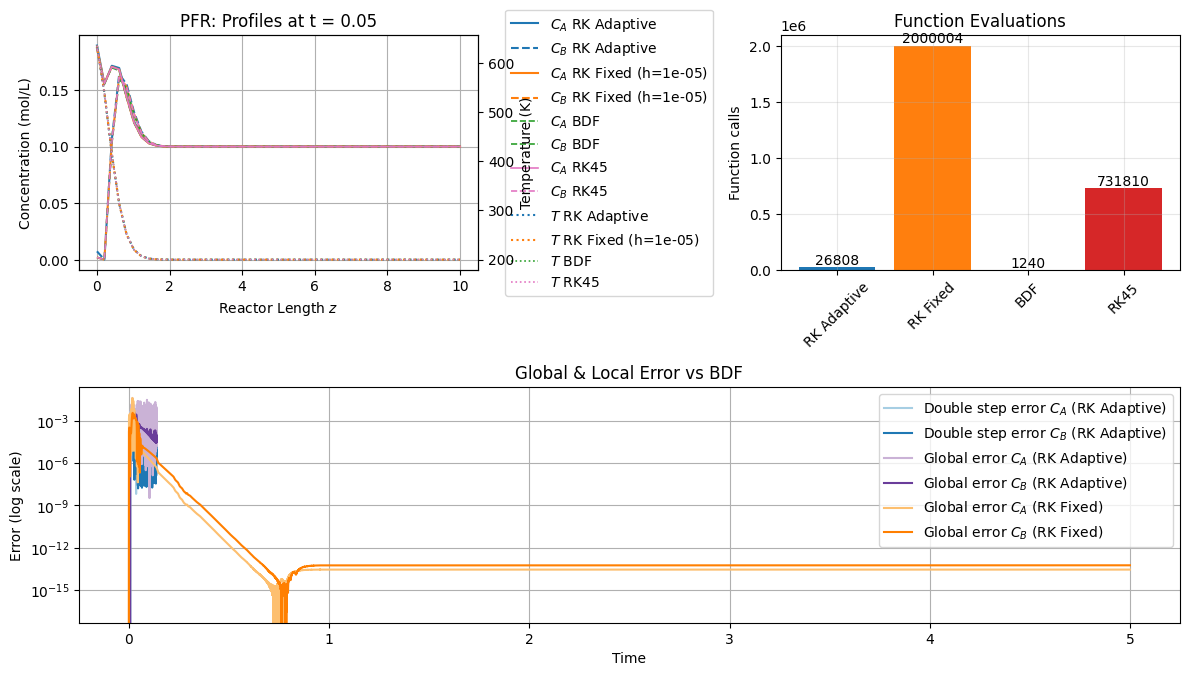

In [323]:
# --- Extract values at t = 0.05 ---
t_target = 0.05
z = np.linspace(0, L, Nz)

# Index of time closest to t=0.05
i_adaptive = np.argmin(np.abs(Tout - t_target))
i_fixed = np.argmin(np.abs(Toutfixed - t_target))
i_bdf = np.argmin(np.abs(sol_ode15s.t - t_target))
i_rk45 = np.argmin(np.abs(sol_ode45.t - t_target))

# Extract for each solver
CA_adapt = Xout[i_adaptive, 0:Nz]
CB_adapt = Xout[i_adaptive, Nz:2*Nz]
T_adapt  = Xout[i_adaptive, 2*Nz:3*Nz]

CA_fixed = Xoutfixed[i_fixed, 0:Nz]
CB_fixed = Xoutfixed[i_fixed, Nz:2*Nz]
T_fixed  = Xoutfixed[i_fixed, 2*Nz:3*Nz]

CA_bdf = sol_ode15s.y[0:Nz, i_bdf]
CB_bdf = sol_ode15s.y[Nz:2*Nz, i_bdf]
T_bdf  = sol_ode15s.y[2*Nz:3*Nz, i_bdf]

CA_rk45 = sol_ode45.y[0:Nz, i_rk45]
CB_rk45 = sol_ode45.y[Nz:2*Nz, i_rk45]
T_rk45  = sol_ode45.y[2*Nz:3*Nz, i_rk45]

# --- Plotting ---
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((3, 2), (0, 0))  # C_A, C_B, T at t=0.05
ax2 = plt.subplot2grid((3, 2), (0, 1))  # Function evaluations
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)  # Error

# --- Plot C_A, C_B on ax1 (left y-axis) ---
ax1.plot(z, CA_adapt, label='$C_A$ RK Adaptive', lw=1.5, color='tab:blue')
ax1.plot(z, CB_adapt, label='$C_B$ RK Adaptive', lw=1.5, linestyle='--', color='tab:blue')

ax1.plot(z, CA_fixed, label=f'$C_A$ RK Fixed (h={h})', lw=1.5, color='tab:orange')
ax1.plot(z, CB_fixed, label=f'$C_B$ RK Fixed (h={h})', lw=1.5, linestyle='--', color='tab:orange')

ax1.plot(z, CA_bdf, label='$C_A$ BDF', lw=1.2, linestyle='--', color='tab:green')
ax1.plot(z, CB_bdf, label='$C_B$ BDF', lw=1.2, linestyle='--', color='tab:green')

ax1.plot(z, CA_rk45, label='$C_A$ RK45', lw=1.2, linestyle='-', color='tab:pink')
ax1.plot(z, CB_rk45, label='$C_B$ RK45', lw=1.2, linestyle='--', color='tab:pink')

ax1.set_xlabel("Reactor Length $z$")
ax1.set_ylabel("Concentration (mol/L)")
ax1.grid(True)

# --- Create right y-axis for Temperature ---
ax1_right = ax1.twinx()

ax1_right.plot(z, T_adapt,  label='$T$ RK Adaptive', lw=1.5,linestyle=':', color='tab:blue')
ax1_right.plot(z, T_fixed,  label=f'$T$ RK Fixed (h={h})', lw=1.5, linestyle=':', color='tab:orange')
ax1_right.plot(z, T_bdf,    label='$T$ BDF', lw=1.2, linestyle=':', color='tab:green')
ax1_right.plot(z, T_rk45,   label='$T$ RK45', lw=1.2, linestyle=':', color='tab:pink')

ax1_right.set_ylabel("Temperature (K)")

# --- Combine legends ---
lines_left, labels_left = ax1.get_legend_handles_labels()
lines_right, labels_right = ax1_right.get_legend_handles_labels()
ax1.legend(lines_left + lines_right, labels_left + labels_right, loc='center left', bbox_to_anchor=(1.05, 0.5))

ax1.set_title("PFR: Profiles at t = 0.05")


# --- Function evaluations ---
methods = ['RK Adaptive', 'RK Fixed', 'BDF', 'RK45']
fcounts = [nfun, nfun_fixed, nfun_bdf, nfun_rk45]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
bars = ax2.bar(methods, fcounts, color=colors)
ax2.set_ylabel("Function calls")
ax2.set_title("Function Evaluations")
ax2.grid(True, alpha=0.3)
for bar, val in zip(bars, fcounts):
    ax2.text(bar.get_x() + bar.get_width()/2., val, f'{val}', ha='center', va='bottom')
ax2.tick_params(axis='x', rotation=45)

# --- Error plot ---
colors = sns.color_palette("Paired")
ax3.plot(Tout, E[:, 0], label='Double step error $C_A$ (RK Adaptive)', color=colors[0])
ax3.plot(Tout, E[:, 1], label='Double step error $C_B$ (RK Adaptive)', color=colors[1])
ax3.plot(Tout, global_err_prey, label='Global error $C_A$ (RK Adaptive)', color=colors[8])
ax3.plot(Tout, global_err_pred, label='Global error $C_B$ (RK Adaptive)', color=colors[9])
ax3.plot(Toutfixed, global_err_fixed_prey, label='Global error $C_A$ (RK Fixed)', color=colors[6])
ax3.plot(Toutfixed, global_err_fixed_pred, label='Global error $C_B$ (RK Fixed)', color=colors[7])
ax3.set_yscale("log")
ax3.set_ylabel("Error (log scale)")
ax3.set_xlabel("Time")
ax3.set_title("Global & Local Error vs BDF")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


In [ ]:



# Plotting
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 2), (0, 0))  # Phase portrait
ax2 = plt.subplot2grid((3, 2), (0, 1))  # Function calls
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)  # Error

# Simulation plot
ax1.plot(Tout, Xout[:, 0], label='$C_A$ RK adaptive', lw=1.5)
ax1.plot(Tout, Xout[:, 1], label='$C_B$ RK adaptive', lw=1.5)
ax1.plot(Toutfixed, Xoutfixed[:, 0], label=f'$C_A$ RK fixed h={h}', lw=1.5)
ax1.plot(Toutfixed, Xoutfixed[:, 1], label=f'$C_B$ RK fixed h={h}', lw=1.5)
ax1.plot(sol_ode15s.t, sol_ode15s.y[0], label='$C_A$ BDF', lw=1)
ax1.plot(sol_ode15s.t, sol_ode15s.y[1], label='$C_B$ BDF', lw=1)
ax1.plot(sol_ode45.t, sol_ode45.y[0], label='$C_A$ RK45', lw=1)
ax1.plot(sol_ode45.t, sol_ode45.y[1], label='$C_B$ RK45', lw=1)
ax1.set_title("PFR 3-state: Solver Comparison")
ax1.set_xlabel("Time")
ax1.set_ylabel("Concentration")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.grid(True)

# Function evaluations bar chart
methods = ['RK Adaptive', 'RK Fixed', 'BDF', 'RK45']
fcounts = [nfun, nfun_fixed, nfun_bdf, nfun_rk45]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
bars = ax2.bar(methods, fcounts, color=colors)
ax2.set_ylabel("Function calls")
ax2.set_title("Function Evaluations")
ax2.grid(True, alpha=0.3)
for bar, val in zip(bars, fcounts):
    ax2.text(bar.get_x() + bar.get_width()/2., val, f'{val}', ha='center', va='bottom')
ax2.tick_params(axis='x', rotation=45)

# Error plot
colors = sns.color_palette("Paired")
ax3.plot(Tout, E[:, 0], label='Double step error $C_A$ (RK Adaptive)', color=colors[0])
ax3.plot(Tout, E[:, 1], label='Double step error $C_B$ (RK Adaptive)', color=colors[1])
ax3.plot(Tout, global_err_prey, label='Global error $C_A$ (RK Adaptive)', color=colors[8])
ax3.plot(Tout, global_err_pred, label='Global error $C_B$ (RK Adaptive)', color=colors[9])
ax3.plot(Toutfixed, global_err_fixed_prey, label='Global error $C_A$ (RK Fixed)', color=colors[6])
ax3.plot(Toutfixed, global_err_fixed_pred, label='Global error $C_B$ (RK Fixed)', color=colors[7])
ax3.set_yscale("log")
ax3.set_ylabel("Error (log)")
ax3.set_xlabel("Time")
ax3.set_title("Error vs BDF (Reference)")
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax3.grid(True)

plt.tight_layout()
plt.show()

## PFR

C:\Users\Bruger\AppData\Local\Temp\ipykernel_14724\2652365652.py:357: RuntimeWarning: overflow encountered in exp
  k = k0 * np.exp(-Ea_over_R / T)
C:\Users\Bruger\AppData\Local\Temp\ipykernel_14724\709854683.py:84: RuntimeWarning: invalid value encountered in divide
  r = np.max(np.abs(e) / denom)  # Compute max ratio


Adaptive step performance
Number of function calls: 20064
Number of accepted steps: 672
Number of rejected steps: 1000
Runtime: 0.9867 seconds

Fixed step performance
Number of function calls: 40004
Runtime: 2.4387 seconds



C:\Users\Bruger\AppData\Local\Temp\ipykernel_14724\2652365652.py:361: RuntimeWarning: overflow encountered in multiply
  RT = v * r
C:\Users\Bruger\AppData\Local\Temp\ipykernel_14724\2652365652.py:357: RuntimeWarning: overflow encountered in multiply
  k = k0 * np.exp(-Ea_over_R / T)


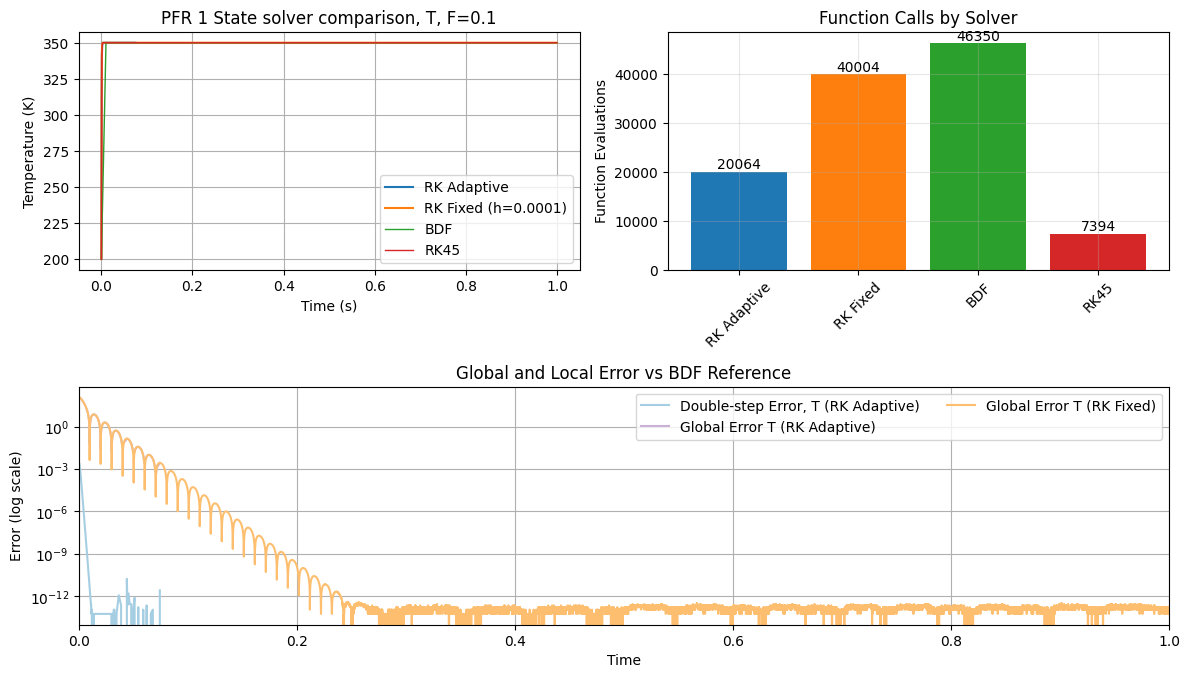

In [ ]:
# --- Settings ---
h = 0.0000001
reltol = 1e-5
abstol = 1e-8
h0 = 1e-6
tspan = (0, 1)
t0 = tspan[0]

# Initial condition and parameters
T0 = np.full(Nz, 200)
Cin = np.array([1.6, 2.4, 350])
deltaHr = -560
rho = 1.0
cp = 4.186
beta = -deltaHr / (rho * cp)
v = beta
F = 0.1

p = {
    'Nz': Nz,
    'dz': deltaz,
    'v': v,
    'F': F,
    'DT': 0.1
}

# --- Adaptive RK ---
start_time = time.time()
Tout, Xout, E, nfun, naccept, nreject = ClassicalRungeKuttaAdaptiveStep(PFR_1state, tspan, T0, h0, abstol, reltol, Cin, p)
runtime_adaptive = time.time() - start_time

print("Adaptive step performance")
print("Number of function calls:", nfun)
print("Number of accepted steps:", naccept)
print("Number of rejected steps:", nreject)
print(f"Runtime: {runtime_adaptive:.4f} seconds\n")

# --- Fixed RK ---
N = int(np.ceil(tspan[1] / h))
start_time = time.time()
Toutfixed, Xoutfixed = RungeKuttaFixedStep(PFR_1state, t0, T0, h, N, A, b, c, Cin, p)
runtime_fixed = time.time() - start_time
nfun_fixed = len(Toutfixed) * len(b)  # each step uses len(b) evaluations

print("Fixed step performance")
print("Number of function calls:", nfun_fixed)
print(f"Runtime: {runtime_fixed:.4f} seconds\n")

# --- BDF (ode15s) ---
t_eval = np.linspace(tspan[0], tspan[1], 1000)
start_time = time.time()
sol_ode15s = solve_ivp(
    fun=lambda t, T: PFR_1state(t, T, Cin, p),
    jac=lambda t, T: PFR1_Jac(t, T, Cin, p),
    t_span=tspan,
    y0=T0,
    method='BDF',
    t_eval=np.linspace(tspan[0], tspan[1], 100)
)
runtime_bdf = time.time() - start_time
nfun_bdf = sol_ode15s.nfev

# --- RK45 ---
start_time = time.time()
sol_ode45 = solve_ivp(PFR_1state, tspan, T0, args=(Cin, p,), t_eval=t_eval, method='RK45')
runtime_rk45 = time.time() - start_time
nfun_rk45 = sol_ode45.nfev

# --- Global error ---
prey_interp = interp1d(sol_ode15s.t, sol_ode15s.y[0], kind='cubic')
global_err_prey = np.abs(Xout[:, 0] - prey_interp(Tout))

prey_interp_fixed = interp1d(sol_ode15s.t, sol_ode15s.y[0], kind='cubic', bounds_error=False, fill_value='extrapolate')
global_err_fixed_prey = np.abs(Xoutfixed[:, 0] - prey_interp_fixed(Toutfixed))

# --- Plot ---
fig = plt.figure(figsize=(12, 10))

# 1. Phase Portrait
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(Tout, Xout[:, 0], label='RK Adaptive', lw=1.5)
ax1.plot(Toutfixed, Xoutfixed[:, 0], label=f'RK Fixed (h={h})', lw=1.5)
ax1.plot(sol_ode15s.t, sol_ode15s.y[0], label='BDF', lw=1)
ax1.plot(sol_ode45.t, sol_ode45.y[0], label='RK45', lw=1)
ax1.set_ylabel("Temperature (K)")
ax1.set_xlabel("Time (s)")
ax1.set_title('PFR 1 State solver comparison, T, F=0.1')
ax1.legend()
ax1.grid(True)

# 2. Function Evaluations
ax2 = plt.subplot2grid((3, 2), (0, 1))
methods = ['RK Adaptive', 'RK Fixed', 'BDF', 'RK45']
function_evals = [nfun, nfun_fixed, nfun_bdf, nfun_rk45]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
bars = ax2.bar(methods, function_evals, color=colors)
ax2.set_ylabel("Function Evaluations")
ax2.set_title("Function Calls by Solver")
ax2.grid(True, alpha=0.3)
for bar, count in zip(bars, function_evals):
    ax2.text(bar.get_x() + bar.get_width() / 2., bar.get_height(), f'{count}', ha='center', va='bottom')
ax2.tick_params(axis='x', rotation=45)

# 3. Global Error
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
colors = sns.color_palette("Paired")
ax3.plot(Tout, E[:, 0], label='Double-step Error, T (RK Adaptive)', color=colors[0])
ax3.plot(Tout, global_err_prey, label='Global Error T (RK Adaptive)', color=colors[8])
ax3.plot(Toutfixed, global_err_fixed_prey, label='Global Error T (RK Fixed)', color=colors[6])
ax3.set_yscale("log")
ax3.set_ylabel("Error (log scale)")
ax3.set_xlabel("Time")
ax3.set_title("Global and Local Error vs BDF Reference")
ax3.legend(loc='upper right', ncol=2)
ax3.set_xlim(tspan)
ax3.grid(True)

plt.tight_layout()
plt.show()
